# Solar

In [29]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Connect to the SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query solar generation data
solar_query = "SELECT datetime, value FROM SUN_data_NE"
solar_data = pd.read_sql_query(solar_query, conn)

conn.close()

In [30]:
# Prepare and clean data
weather_data = weather_data.rename(columns={'time': 'datetime'})
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
solar_data['datetime'] = pd.to_datetime(solar_data['datetime'])

# Add temporal features to weather data
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = np.where(weather_data['datetime'].dt.month.isin([12, 1, 2]), 1,
                                  np.where(weather_data['datetime'].dt.month.isin([3, 4, 5]), 2,
                                           np.where(weather_data['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))

# Merge weather and solar data
merged_data = pd.merge(weather_data, solar_data, on='datetime', how='inner')

# Prepare features and target
X = merged_data[['temperature', 'dwpt', 'humidity', 'precipitation',
                 'wdir', 'windspeed', 'pres', 'cloudcover', 'hour', 'month', 'season']].values
y = merged_data[['value']].values

In [31]:
# Scale features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X_scaled = scaler_features.fit_transform(X)
y_scaled = scaler_target.fit_transform(y)

In [32]:
# Create sequences for LSTM
def create_sequences(data_X, data_y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(data_X) - seq_length):
        X_seq.append(data_X[i:i+seq_length])
        y_seq.append(data_y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length=sequence_length)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [33]:
# Define the LSTM model
class SolarRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(SolarRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

In [34]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 32

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SolarRNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [35]:
# Training loop
model.train()
train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 0.0188
Epoch 2/20, Loss: 0.0090
Epoch 3/20, Loss: 0.0084
Epoch 4/20, Loss: 0.0076
Epoch 5/20, Loss: 0.0074
Epoch 6/20, Loss: 0.0070
Epoch 7/20, Loss: 0.0070
Epoch 8/20, Loss: 0.0067
Epoch 9/20, Loss: 0.0067
Epoch 10/20, Loss: 0.0066
Epoch 11/20, Loss: 0.0063
Epoch 12/20, Loss: 0.0063
Epoch 13/20, Loss: 0.0064
Epoch 14/20, Loss: 0.0062
Epoch 15/20, Loss: 0.0061
Epoch 16/20, Loss: 0.0060
Epoch 17/20, Loss: 0.0059
Epoch 18/20, Loss: 0.0059
Epoch 19/20, Loss: 0.0058
Epoch 20/20, Loss: 0.0056


In [36]:
# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    all_predictions = model(X_test_tensor).cpu().numpy()
    all_actuals = y_test_tensor.numpy()

# Inverse transform all predictions and actuals
all_predictions_inverse = scaler_target.inverse_transform(all_predictions)
all_actuals_inverse = scaler_target.inverse_transform(all_actuals)

# Calculate metrics using full test set
mae = mean_absolute_error(all_actuals_inverse, all_predictions_inverse)
rmse = np.sqrt(mean_squared_error(all_actuals_inverse, all_predictions_inverse))
r2 = r2_score(all_actuals_inverse, all_predictions_inverse)

print(f"Solar (Full Test Set) - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

Solar (Full Test Set) - MAE: 34.10, RMSE: 59.10, R²: 0.90


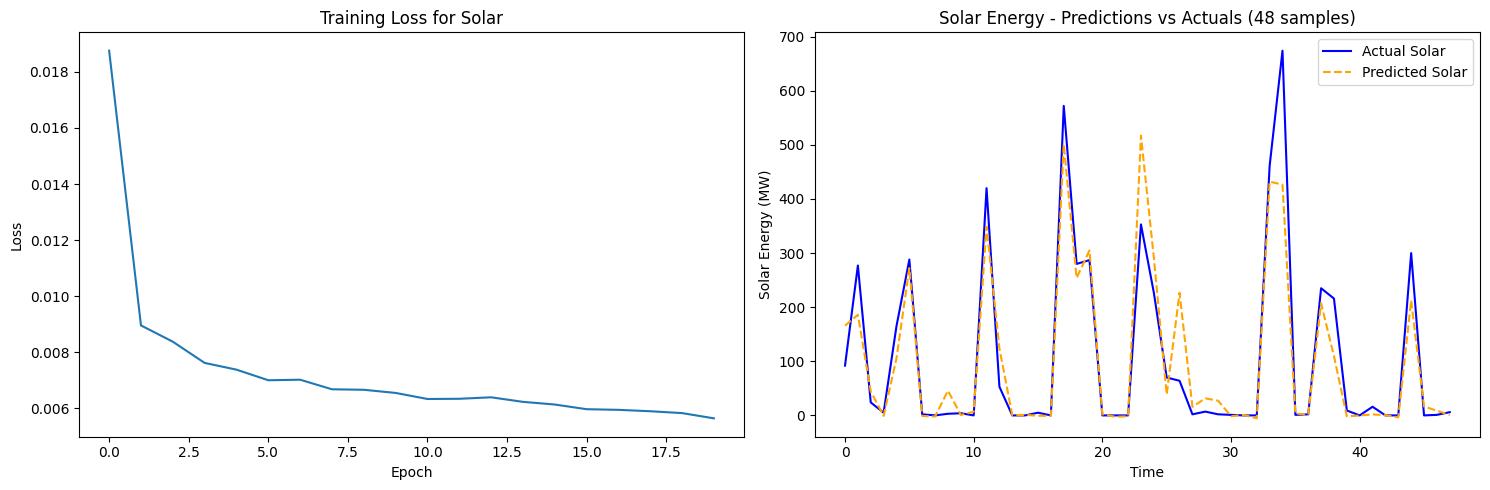

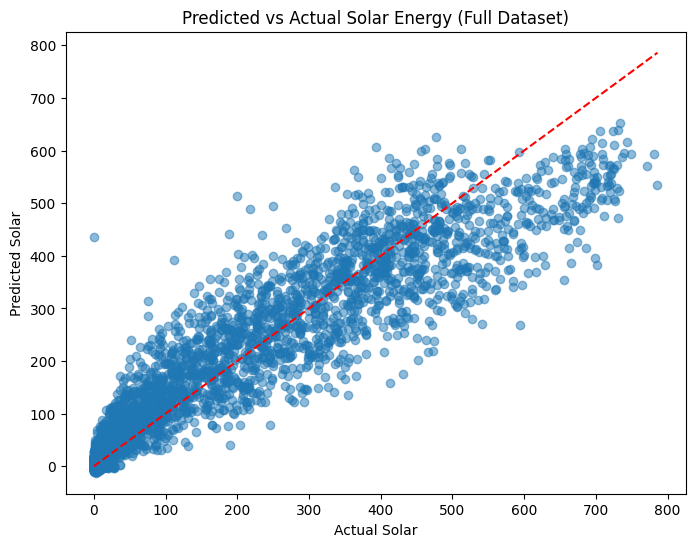

In [37]:
# Visualize results
plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss for Solar")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Predictions vs Actuals (48 samples)
plt.subplot(1, 2, 2)
plt.plot(all_actuals_inverse[:48], label="Actual Solar", color="blue")
plt.plot(all_predictions_inverse[:48], label="Predicted Solar", color="orange", linestyle="--")
plt.title("Solar Energy - Predictions vs Actuals (48 samples)")
plt.xlabel("Time")
plt.ylabel("Solar Energy (MW)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Scatter plot for all data points
plt.figure(figsize=(8, 6))
plt.scatter(all_actuals_inverse, all_predictions_inverse, alpha=0.5)
plt.title("Predicted vs Actual Solar Energy (Full Dataset)")
plt.xlabel("Actual Solar")
plt.ylabel("Predicted Solar")
plt.plot([0, np.max(all_actuals_inverse)], [0, np.max(all_actuals_inverse)],
         color="red", linestyle="--")  # Reference diagonal
plt.show()

# Demand

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query demand data
demand_query = "SELECT datetime, Demand as value FROM demand_data_NE"
demand_data = pd.read_sql_query(demand_query, conn)

conn.close()

In [9]:
# Preprocess weather data
weather_data.rename(columns={'time': 'datetime'}, inplace=True)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Add temporal features
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = ((weather_data['datetime'].dt.month - 1) // 3 + 1).astype(int)

# Preprocess demand data
demand_data['datetime'] = pd.to_datetime(demand_data['datetime'])

# Merge weather and demand data
merged_demand = pd.merge(weather_data, demand_data, on='datetime', how='inner')

# Add temporal features
merged_demand['hour'] = merged_demand['datetime'].dt.hour
merged_demand['month'] = merged_demand['datetime'].dt.month
merged_demand['season'] = np.where(merged_demand['datetime'].dt.month.isin([12, 1, 2]), 1,
                                   np.where(merged_demand['datetime'].dt.month.isin([3, 4, 5]), 2,
                                            np.where(merged_demand['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))
merged_demand['time_of_day'] = np.where(merged_demand['datetime'].dt.hour < 6, 1,
                                        np.where(merged_demand['datetime'].dt.hour < 12, 2,
                                                 np.where(merged_demand['datetime'].dt.hour < 18, 3, 4)))

In [10]:
# Scale features and target
scaler_features_demand = MinMaxScaler()
scaled_features_demand = scaler_features_demand.fit_transform(merged_demand[[
    'temperature', 'dwpt', 'humidity', 'precipitation',
    'wdir', 'windspeed', 'pres', 'cloudcover', 'hour', 'month', 'season', 'time_of_day'
]])
scaler_target_demand = MinMaxScaler()
scaled_target_demand = scaler_target_demand.fit_transform(merged_demand[['value']])

In [11]:
class EnergyDataset(Dataset):
    def __init__(self, features, targets, sequence_length):
        self.features = features
        self.targets = targets
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.sequence_length]
        y = self.targets[idx + self.sequence_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Create dataset
sequence_length = 24
demand_dataset = EnergyDataset(scaled_features_demand, scaled_target_demand, sequence_length)

# Split data into train and test sets
train_size = int(0.7 * len(demand_dataset))
test_size = len(demand_dataset) - train_size
train_demand, test_demand = torch.utils.data.random_split(demand_dataset, [train_size, test_size])

In [12]:
class EnergyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(EnergyRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

In [15]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
learning_rate = 0.001
num_epochs = 20

# DataLoaders
train_loader_demand = DataLoader(train_demand, batch_size=batch_size, shuffle=True)
test_loader_demand = DataLoader(test_demand, batch_size=batch_size, shuffle=False)

# Model, optimizer, and criterion
input_size = scaled_features_demand.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1

model_demand = EnergyRNN(input_size, hidden_size, output_size, num_layers).to(device)
optimizer_demand = torch.optim.Adam(model_demand.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [16]:
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return losses

# Train the model
losses_demand = train_model(model_demand, train_loader_demand, optimizer_demand, criterion, num_epochs)

Epoch 1/20, Loss: 0.0126
Epoch 2/20, Loss: 0.0050
Epoch 3/20, Loss: 0.0040
Epoch 4/20, Loss: 0.0033
Epoch 5/20, Loss: 0.0031
Epoch 6/20, Loss: 0.0029
Epoch 7/20, Loss: 0.0027
Epoch 8/20, Loss: 0.0028
Epoch 9/20, Loss: 0.0026
Epoch 10/20, Loss: 0.0026
Epoch 11/20, Loss: 0.0024
Epoch 12/20, Loss: 0.0024
Epoch 13/20, Loss: 0.0023
Epoch 14/20, Loss: 0.0025
Epoch 15/20, Loss: 0.0022
Epoch 16/20, Loss: 0.0021
Epoch 17/20, Loss: 0.0021
Epoch 18/20, Loss: 0.0021
Epoch 19/20, Loss: 0.0020
Epoch 20/20, Loss: 0.0021


In [17]:
def evaluate_model(model, test_loader, scaler):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch).cpu().numpy()
            predictions.extend(outputs)
            actuals.extend(y_batch.numpy())

    # Convert to arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Inverse transform predictions and actuals
    predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))
    actuals_inverse = scaler.inverse_transform(actuals.reshape(-1, 1))

    return predictions_inverse, actuals_inverse

# Evaluate the model
predictions_demand, actuals_demand = evaluate_model(model_demand, test_loader_demand, scaler_target_demand)

Demand (Full Test Set) - MAE: 635.41, RMSE: 822.65, R²: 0.89


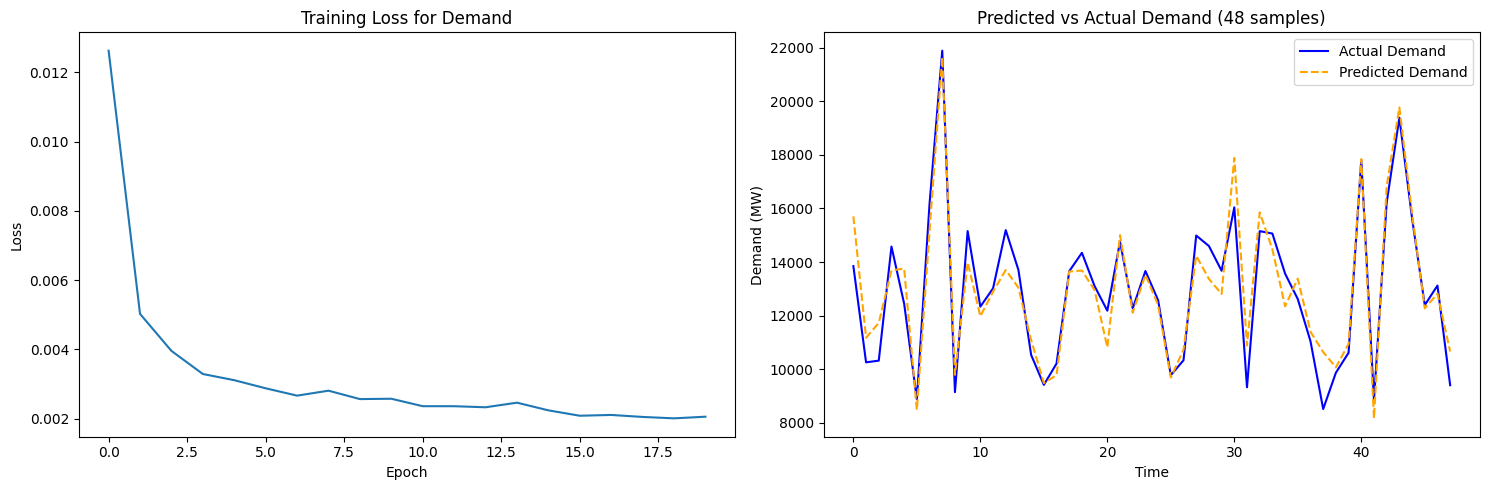

In [18]:
# Calculate metrics using full dataset
mae_demand = mean_absolute_error(actuals_demand, predictions_demand)
rmse_demand = np.sqrt(mean_squared_error(actuals_demand, predictions_demand))
r2_demand = r2_score(actuals_demand, predictions_demand)

print(f"Demand (Full Test Set) - MAE: {mae_demand:.2f}, RMSE: {rmse_demand:.2f}, R²: {r2_demand:.2f}")

# Visualize predicted vs actual demand
plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(losses_demand)
plt.title("Training Loss for Demand")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Predictions vs Actuals (48 samples)
plt.subplot(1, 2, 2)
plt.plot(actuals_demand[:48], label="Actual Demand", color="blue")
plt.plot(predictions_demand[:48], label="Predicted Demand", linestyle="--", color="orange")
plt.title("Predicted vs Actual Demand (48 samples)")
plt.xlabel("Time")
plt.ylabel("Demand (MW)")
plt.legend()
plt.tight_layout()
plt.show()

## Wind

In [19]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Connect to the SQLite database
conn = sqlite3.connect("energy_data_NE.db")

# Query weather data
weather_query = """
SELECT time, temperature, dwpt, humidity, precipitation, wdir, windspeed, pres, cloudcover
FROM historical_weather_data
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Query wind generation data
wind_query = "SELECT datetime, value FROM WND_data_NE"
wind_data = pd.read_sql_query(wind_query, conn)

conn.close()

In [20]:
# Prepare and clean data
weather_data = weather_data.rename(columns={'time': 'datetime'})
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
wind_data['datetime'] = pd.to_datetime(wind_data['datetime'])

# Add temporal features to weather data
weather_data['hour'] = weather_data['datetime'].dt.hour
weather_data['month'] = weather_data['datetime'].dt.month
weather_data['season'] = np.where(weather_data['datetime'].dt.month.isin([12, 1, 2]), 1,
                                  np.where(weather_data['datetime'].dt.month.isin([3, 4, 5]), 2,
                                           np.where(weather_data['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))

# Merge weather and wind data
merged_data = pd.merge(weather_data, wind_data, on='datetime', how='inner')

# Prepare features and target
X = merged_data[['temperature', 'dwpt', 'humidity', 'precipitation',
                 'wdir', 'windspeed', 'pres', 'cloudcover', 'hour', 'month', 'season']].values
y = merged_data[['value']].values

In [21]:
# Scale features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X_scaled = scaler_features.fit_transform(X)
y_scaled = scaler_target.fit_transform(y)

In [22]:
# Create sequences for LSTM
def create_sequences(data_X, data_y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(data_X) - seq_length):
        X_seq.append(data_X[i:i+seq_length])
        y_seq.append(data_y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length=sequence_length)

In [23]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [24]:
# Define the LSTM model
class WindRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(WindRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

In [25]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 32

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WindRNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [26]:
# Training loop
model.train()
train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 0.0343
Epoch 2/20, Loss: 0.0272
Epoch 3/20, Loss: 0.0255
Epoch 4/20, Loss: 0.0242
Epoch 5/20, Loss: 0.0230
Epoch 6/20, Loss: 0.0227
Epoch 7/20, Loss: 0.0222
Epoch 8/20, Loss: 0.0218
Epoch 9/20, Loss: 0.0210
Epoch 10/20, Loss: 0.0202
Epoch 11/20, Loss: 0.0198
Epoch 12/20, Loss: 0.0195
Epoch 13/20, Loss: 0.0190
Epoch 14/20, Loss: 0.0186
Epoch 15/20, Loss: 0.0178
Epoch 16/20, Loss: 0.0174
Epoch 17/20, Loss: 0.0169
Epoch 18/20, Loss: 0.0164
Epoch 19/20, Loss: 0.0157
Epoch 20/20, Loss: 0.0152


In [27]:
# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    all_predictions = model(X_test_tensor).cpu().numpy()
    all_actuals = y_test_tensor.numpy()

# Inverse transform all predictions and actuals
all_predictions_inverse = scaler_target.inverse_transform(all_predictions)
all_actuals_inverse = scaler_target.inverse_transform(all_actuals)

# Calculate metrics using full test set
mae = mean_absolute_error(all_actuals_inverse, all_predictions_inverse)
rmse = np.sqrt(mean_squared_error(all_actuals_inverse, all_predictions_inverse))
r2 = r2_score(all_actuals_inverse, all_predictions_inverse)

print(f"Wind (Full Test Set) - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

Wind (Full Test Set) - MAE: 119.49, RMSE: 152.07, R²: 0.72


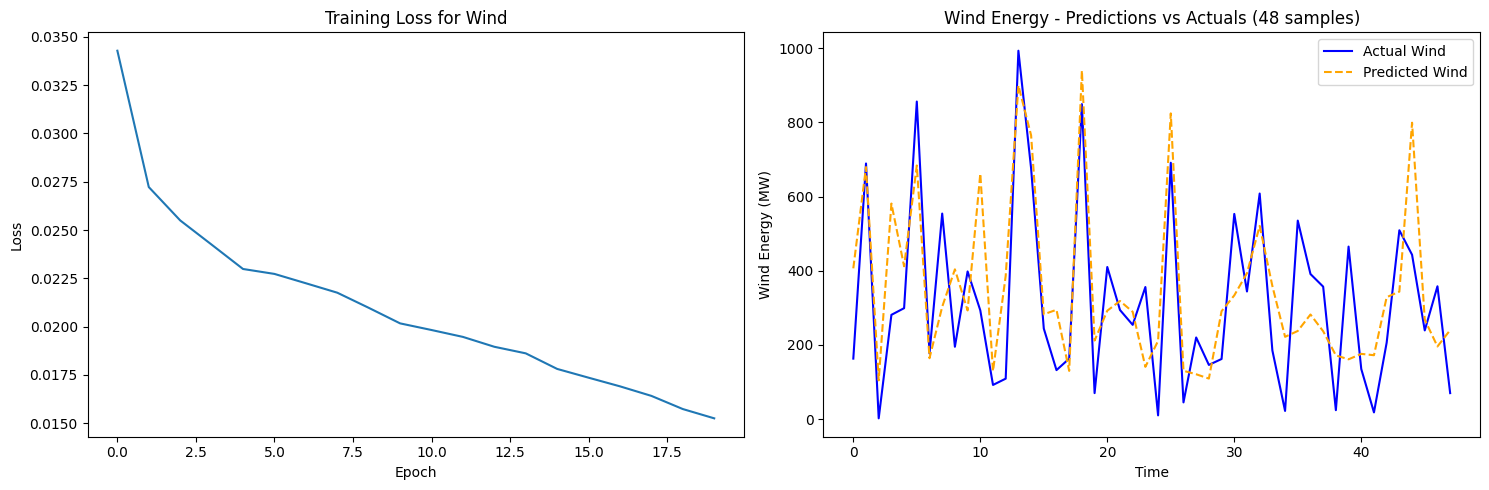

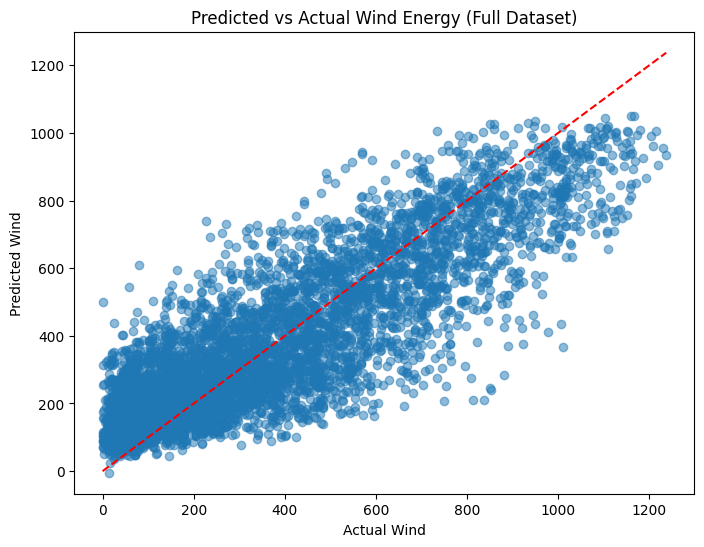

In [28]:
# Visualize results
plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss for Wind")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Predictions vs Actuals (48 samples)
plt.subplot(1, 2, 2)
plt.plot(all_actuals_inverse[:48], label="Actual Wind", color="blue")
plt.plot(all_predictions_inverse[:48], label="Predicted Wind", color="orange", linestyle="--")
plt.title("Wind Energy - Predictions vs Actuals (48 samples)")
plt.xlabel("Time")
plt.ylabel("Wind Energy (MW)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Scatter plot for all data points
plt.figure(figsize=(8, 6))
plt.scatter(all_actuals_inverse, all_predictions_inverse, alpha=0.5)
plt.title("Predicted vs Actual Wind Energy (Full Dataset)")
plt.xlabel("Actual Wind")
plt.ylabel("Predicted Wind")
plt.plot([0, np.max(all_actuals_inverse)], [0, np.max(all_actuals_inverse)],
         color="red", linestyle="--")  # Reference diagonal
plt.show()